# WELCOME

**Here in this notebook we will take a look on how to operate with DICOM files format.**

In [ ]:
# First, let's import useful pyhton libraries
!pip install pydicom
import pydicom
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import os
import time
import numpy as np
import cv2
import numpy as np

     |████████████████████████████████| 2.0 MB 32.4 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install kaggle

from google.colab import files
files.upload()

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"escyubinhong","key":"0ebc417993db73eb003575ab871df771"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c unifesp-x-ray-body-part-classifier

%cd /content
!unzip -qq "/content/unifesp-x-ray-body-part-classifier.zip"

100% 29.9G/29.9G [02:15<00:00, 302MB/s]
100% 29.9G/29.9G [02:15<00:00, 237MB/s]
/content
train/train/105/1.2.826.0.1.3680043.8.498.69354341185657547839597875342198315357/1.2.826.0.1.3680043.8.498.12134454176298616813557975022908945891/1.2.826.0.1.3680043.8.498.58213184485269370195749656926304054870-c.dcm:  write error (disk full?).  Continue? (y/n/^C) 

/content
train/train/105/1.2.826.0.1.3680043.8.498.69354341185657547839597875342198315357/1.2.826.0.1.3680043.8.498.12134454176298616813557975022908945891/1.2.826.0.1.3680043.8.498.58213184485269370195749656926304054870-c.dcm:  write error (disk full?).  Continue? (y/n/^C) y
train/train/105/1.2.826.0.1.3680043.8.498.69354341185657547839597875342198315357/1.2.826.0.1.3680043.8.498.12134454176298616813557975022908945891/1.2.826.0.1.3680043.8.498.58213184485269370195749656926304054870-c.dcm  bad CRC 7401e4a1  (should be 59bfd89d)
checkdir error:  cannot create train/train/105/1.2.826.0.1.3680043.8.498.69354341185657547839597875342198315357/1.2.826.0.1.3680043.8.498.32319380150047810418367669474369091490
                 No space left on device
                 unable to process train/train/105/1.2.826.0.1.3680043.8.498.69354341185657547839597875342198315357/1.2.826.0.1.3680043.8.498.32319380150047810418367669474369091490/1.2.826.0.1.3680043.8.498.68088603689755131947964416999586816538-c.d

In [ ]:
# Let's take a look on the training csv file.

train_df = pd.read_csv('/content/train.csv')

In [ ]:
train_df.head(8)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,3
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,14
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,13 20


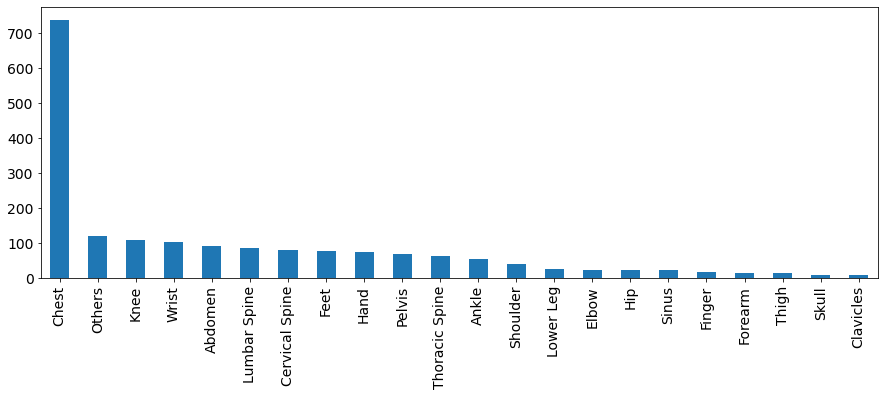

In [ ]:
#Let's  see our Target distribution

bodyparts = {
0 : 'Abdomen' ,
1 :'Ankle' ,
2 :'Cervical Spine',
3 : 'Chest' ,
4 :'Clavicles' ,
5 :'Elbow' ,
6 :'Feet' ,
7 : 'Finger' ,
8 : 'Forearm' ,
9 : 'Hand' ,
10 : 'Hip' ,
11 : 'Knee' ,
12 : 'Lower Leg' ,
13 : 'Lumbar Spine' ,
14 : 'Others' ,
15 :'Pelvis',
16 :'Shoulder' ,
17 :'Sinus' ,
18 : 'Skull' ,
19 : 'Thigh' ,
20 :'Thoracic Spine',
21: 'Wrist',
}

labels_num = [value.split() for value in train_df['Target']]
labels_num_flat = list(map(int, [item for sublist in labels_num for item in sublist]))
labels = ["" for _ in range(len(labels_num_flat))]
for i in range(len(labels_num_flat)):
    labels[i] = bodyparts[labels_num_flat[i]]

fig, ax = plt.subplots(figsize=(15, 5))
pd.Series(labels).value_counts().plot(kind = 'bar', fontsize=14)

In [ ]:
#DICOM file formats contains meta-data that can be useful for deep learning model preprocessing
#I'll use a funciton created by Felipe Kitamura to list the DICOM Tags from the files

def dcmtag2table(folder, list_of_tags):
    """
    # Create a Pandas DataFrame with the <list_of_tags> DICOM tags
    # from the DICOM files in <folder>
    # Parameters:
    #    folder (str): folder to be recursively walked looking for DICOM files.
    #    list_of_tags (list of strings): list of DICOM tags with no whitespaces.
    # Returns:
    #    df (DataFrame): table of DICOM tags from the files in folder.
    """
    list_of_tags = list_of_tags.copy()
    items = []
    table = []
    filelist = []
    print("Listing all files...")
    start = time.time()
    for root, dirs, files in os.walk(folder, topdown=False):
        for name in files:
            filelist.append(os.path.join(root, name))
    print("Time: " + str(time.time() - start))
    print("Reading files...")
    time.sleep(2)
    for _f in tqdm(filelist):
        try:
            ds = pydicom.dcmread(_f, stop_before_pixels=True)
            items = []
            items.append(_f)

            for _tag in list_of_tags:
                if _tag in ds:
                    items.append(ds.data_element(_tag).value)
                else:
                    items.append("Not found")

            table.append((items))
        except:
            print("Skipping non-DICOM: " + _f)

            
    list_of_tags.insert(0, "Filename")
    test = list(map(list, zip(*table)))
    dictone = {}

    for i, _tag in enumerate (list_of_tags):
        dictone[_tag] = test[i]

    df = pd.DataFrame(dictone)
    time.sleep(2)
    print("Finished.")
    return df

In [ ]:
tags = ['PhotometricInterpretation','BitsAllocated', 'SOPInstanceUID' ]
dicom_tags_train =  dcmtag2table('/content/train', tags)

Listing all files...
Time: 0.32427287101745605
Reading files...


100%|██████████| 1738/1738 [00:05<00:00, 291.50it/s]


Finished.


In [ ]:
dicom_tags_train.head()

,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID
0,/content/train/train/256/1.2.826.0.1.3680043.8...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.19325085101380021176...
1,/content/train/train/93/1.2.826.0.1.3680043.8....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11484980830089725815...
2,/content/train/train/93/1.2.826.0.1.3680043.8....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.10383881925699143675...
3,/content/train/train/93/1.2.826.0.1.3680043.8....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.30281657745032393199...
4,/content/train/train/336/1.2.826.0.1.3680043.8...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.72387851843466159412...


In [ ]:
#Let's see the differente type of Photometric Interpreation and how it affects the display of an image

print(dicom_tags_train.PhotometricInterpretation.value_counts())

print('The following images are with Photometric Interpretation MONOCHROME1')
n = 0
for idx,row in dicom_tags_train[dicom_tags_train.PhotometricInterpretation == 'MONOCHROME1'].iterrows():
    dicom = pydicom.dcmread(row.Filename)
    img = dicom.pixel_array
    plt.imshow(img, cmap = 'gray')
    plt.show()
    n += 1
    if n == 1:
        break

print('The following images are with Photometric Interpretation MONOCHROME2')

n = 0
for idx, row in dicom_tags_train[dicom_tags_train.PhotometricInterpretation == 'MONOCHROME2'].iterrows():
    dicom = pydicom.dcmread(row.Filename)
    img = dicom.pixel_array
    plt.imshow(img, cmap = 'gray')
    plt.show()
    n += 1
    if n == 1:
        break

NameError: ignored

As you can see, the Photometric Interpretation changes hwo the density of the elements presents in the body will be shown. 
In MONOCHROME1 the element in the image with less density (air) is brighter, the reverse happens in MONCHROME2

The following images are with Photometric Interpretation MONOCHROME1 but will be displayed as MONCHROME2


/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


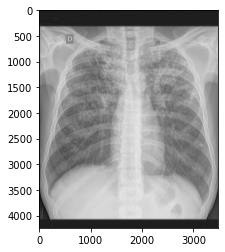

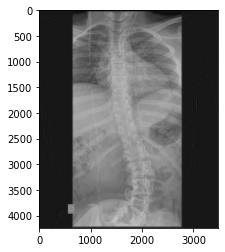

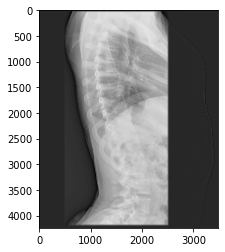

In [ ]:
#You can use numpy invert() funciton to change the display of the Photometric Interpratation between two different MONCHROMEs

print('The following images are with Photometric Interpretation MONOCHROME1 but will be displayed as MONCHROME2')
n = 0
for idx,row in dicom_tags_train[dicom_tags_train.PhotometricInterpretation == 'MONOCHROME1'].iterrows():
    dicom = pydicom.dcmread(row.Filename)
    img = dicom.pixel_array
    plt.imshow(np.invert(img), cmap = 'gray')
    plt.show()
    n += 1
    if n == 3:
        break

In [ ]:
train = dicom_tags_train.merge(train_df, on =  'SOPInstanceUID')

In [ ]:
train.head()

,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target
0,/content/train/train/256/1.2.826.0.1.3680043.8...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.19325085101380021176...,3
1,/content/train/train/93/1.2.826.0.1.3680043.8....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11484980830089725815...,14
2,/content/train/train/93/1.2.826.0.1.3680043.8....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.10383881925699143675...,20
3,/content/train/train/93/1.2.826.0.1.3680043.8....,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.30281657745032393199...,15
4,/content/train/train/336/1.2.826.0.1.3680043.8...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.72387851843466159412...,11


In [ ]:
#What about seeing how a baseline model works??
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, Dense, LeakyReLU
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.random import set_seed
from tensorflow.keras.activations import sigmoid

import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import itertools
from tensorflow.keras.models import load_model

os.environ["CUDA_VISIBLE_DEVICES"]="0" # first gpu
set_seed(1234)

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
reverse_train_labels = dict((v,k) for k,v in bodyparts.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" "))
    for num in row.Target:
        if num != '':
            name = bodyparts[int(num)]
            row.loc[name] = 1
    return row

In [ ]:
for key in bodyparts.keys():
    train_df[bodyparts[key]] = 0

In [ ]:
train_labels = train_df.apply(fill_targets, axis=1)
train_labels.head()

,SOPInstanceUID,Target,Abdomen,Ankle,Cervical Spine,Chest,Clavicles,Elbow,Feet,Finger,...,Lower Leg,Lumbar Spine,Others,Pelvis,Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,"[0, ]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,"[15, ]",0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,"[12, ]",0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,"[14, ]",0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,"[3, ]",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train = dicom_tags_train.merge(train_labels, on =  'SOPInstanceUID')

In [ ]:
train.head()

,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Abdomen,Ankle,Cervical Spine,Chest,Clavicles,...,Lower Leg,Lumbar Spine,Others,Pelvis,Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist
0,../input/unifesp-xray-bodypart-classification/...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.71157989004260882669...,"[3, ]",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,../input/unifesp-xray-bodypart-classification/...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.32467620439025796224...,"[4, ]",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,../input/unifesp-xray-bodypart-classification/...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.74856220852423198555...,"[4, ]",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,../input/unifesp-xray-bodypart-classification/...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.90865692473901867788...,"[7, ]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,../input/unifesp-xray-bodypart-classification/...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.44687741644515558201...,"[21, ]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
train.iloc[:,5:]

,Abdomen,Ankle,Cervical Spine,Chest,Clavicles,Elbow,Feet,Finger,Forearm,Hand,...,Lower Leg,Lumbar Spine,Others,Pelvis,Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1734,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
labels = ['Abdomen', 'Ankle', 'Cervical Spine',
       'Chest', 'Clavicles', 'Elbow', 'Feet', 'Finger', 'Forearm', 'Hand',
       'Hip', 'Knee', 'Lower Leg', 'Lumbar Spine', 'Others', 'Pelvis',
       'Shoulder', 'Sinus', 'Skull', 'Thigh', 'Thoracic Spine', 'Wrist']

In [ ]:
class XrayDataLoader(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, shuffle_df=True):
        self.df = data
        self.bs = batch_size

        if shuffle_df == True:
            self.df = self.df.sample(frac = 1.)
        
    def __len__(self):
        return len(self.df) // self.bs

    def __getitem__(self, idx):
        start = idx * self.bs
        end = (idx+1) * self.bs
        
        
        
        paths = self.df[start:end]
        X = []
        Y = []
        
        for j, path in paths.iterrows():
            dcm = pydicom.dcmread(path.Filename)
            img = dcm.pixel_array
            
            if np.random.choice([0,1]):
                img = np.invert(img)
            
            if len(img.shape) > 2:
                for i in range(0, len(img.shape[0])):
                    img =  img[i, : , :]
                    img = img / img.max() - 0.5
                    #img = cv2.resize(img, (256, 256)) 

                    img = img.astype(np.float32)
                    X.append(img)
                    Y.append(path[5:])
                    break
            else:
                img = img / img.max() - 0.5
                #img = cv2.resize(img, (256, 256)) 

                img = img.astype(np.float32)
                X.append(img)
                Y.append(path[5:])  

        X = np.repeat(np.asarray(X).astype(np.float32)[..., np.newaxis], 3, axis= 3)


        Y = np.asarray(Y).astype(np.float32)

        
        return X, Y

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, val = train_test_split(train,test_size =0.2, random_state= 42)

In [ ]:
train_gen = XrayDataLoader(train, 8)
val_gen = XrayDataLoader(val, 8, shuffle_df = False)

In [ ]:
#train_gen[0][0].shape

In [ ]:
with tf.device('/device:gpu:0'):
    callback_sv = ModelCheckpoint(filepath = './model.h5',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    monitor="val_loss",                           
    mode="min",
    save_freq="epoch")

    callback_rl = ReduceLROnPlateau(
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr =1e-7, 
    mode="auto")

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

    callbacks =[callback_sv,callback_rl, es]

    model = VGG16(include_top=False, input_shape=(256, 256, 3), weights="imagenet")

    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = True

        # add new classifier layers
    flat1 = GlobalAveragePooling2D()(model.layers[-1].output)
    flat2 = Dropout(0.3)(flat1)
    class1 = Dense(64, activation='relu', kernel_initializer='he_uniform')(flat2)
    class2 = Dense(32, activation='relu', kernel_initializer='he_uniform')(class1)
    output = Dense(22, activation='sigmoid')(class2)

    # define new model
    model = Model(inputs=model.inputs, outputs=output)

    # compile model
    opt = Adam(lr=0.000001)#, momentum=0.9)
    model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

2022-04-15 23:03:16.357443: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-15 23:03:16.358741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 23:03:16.359679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 23:03:16.360405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

58900480/58889256 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
with tf.device('/device:gpu:0'):
    history=model.fit(train_gen,steps_per_epoch=len(train_gen), validation_data=val_gen,
              validation_steps=len(val_gen),epochs=50 , workers = 6,
              max_queue_size =6, use_multiprocessing = True, callbacks= callbacks)

2022-04-15 23:03:19.865634: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-15 23:03:21.893222: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


173/173 [==============================] - 27s 105ms/step - loss: 3.3825 - accuracy: 0.0347 - val_loss: 3.1433 - val_accuracy: 0.3924
Epoch 2/50
173/173 [==============================] - 19s 107ms/step - loss: 3.0969 - accuracy: 0.3085 - val_loss: 2.8978 - val_accuracy: 0.3924
Epoch 3/50
173/173 [==============================] - 19s 104ms/step - loss: 2.9123 - accuracy: 0.3981 - val_loss: 2.6907 - val_accuracy: 0.4099
Epoch 4/50
173/173 [==============================] - 19s 104ms/step - loss: 2.7664 - accuracy: 0.4169 - val_loss: 2.6019 - val_accuracy: 0.4128
Epoch 5/50
173/173 [==============================] - 18s 103ms/step - loss: 2.6672 - accuracy: 0.4176 - val_loss: 2.4769 - val_accuracy: 0.4157
Epoch 6/50
173/173 [==============================] - 18s 104ms/step - loss: 2.5308 - accuracy: 0.4386 - val_loss: 2.3490 - val_accuracy: 0.4477
Epoch 7/50
173/173 [==============================] - 19s 107ms/step - loss: 2.4182 - accuracy: 0.4523 - val_loss: 2.1828 - val_accuracy: 0.4

In [ ]:
## We will keep adding valuable information!
#Enjoy the competition